In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import defaultdict
from sklearn.metrics import confusion_matrix

In [2]:
def getClassProbs(classData):
    # returns natural log-probabilities for numerical stability

    classMap = {j:i for i,j in enumerate(classData.unique())}
    invClassMap = {i:j for i,j in enumerate(classData.unique())}
    count = defaultdict(lambda : 0)
    for i in classData:
        count[i] +=1
    classProbs = {}
    for i in list(classMap.keys()):
        #calculating probabilities using Laplace Add-1 Smoothing
        classProbs[classMap[i]] = np.log(count[i]+1) - np.log(sum(count.values())+len(count.keys()))
    return classProbs, classMap, invClassMap

#building n-gram model
def getNgrams(inText : str, n : int):
    if n == 1:
        return inText.split()
    nGrams = []
    inText = inText.split()
    for i in range(0,len(inText)-(n-1)):
        nGrams.append(tuple(inText[i:i+n]))
    return nGrams
    
def getCounts(train,cMap,n = 1):
    mainCount = defaultdict(lambda : defaultdict(lambda : 0)) # counts prob wrd|class
    allCount = defaultdict(lambda : 0) # keeps a count of all words occuring to get vocab size
    denom = defaultdict(lambda : 0)
    for i,j in zip(train['Sentiment'],train['CoronaTweet']):
        splitt = getNgrams(j,n)
        for wrd in splitt:
            mainCount[cMap[i]][wrd] += 1 #not adding +1 for smoothing. At prediction time add +1 to all prediction such that 0 occ also get 1
            allCount[wrd] +=1
        denom[cMap[i]] += len(splitt)
    vocabSize = len(list(allCount.keys()))
    #adding |V| for laplace smoothing
    for i in list(denom.keys()):
        denom[i]+= vocabSize
    
    return mainCount, denom

def getPredProbClass(inText: list, k : int, count : defaultdict, denom : defaultdict):
    textProb = 0
    for i in inText:
        textProb += np.log(count[k][i] + 1)- np.log(denom[k])
    return textProb

def predict(inText : str, nGrams : list, cProbs : dict , icMap : dict):
    # count is a list of tuples : (n, count, denom)
    probs = []
    for i in list(cProbs.keys()):
        prob = 0
        for gram in nGrams:
            prob += getPredProbClass(getNgrams(inText,gram[0]), i, gram[1], gram[2])
        probs.append(prob + cProbs[i])
    return icMap[np.argmax(np.array(probs))],probs


In [3]:
trainSourceRaw = pd.read_csv('data/Corona_train.csv')
testSourceRaw = pd.read_csv("data/Corona_validation.csv")

In [4]:
'''for i in range(len(trainSourceRaw)):
    trainSourceRaw.loc[i,'CoronaTweet'] = trainSourceRaw.loc[i,'CoronaTweet'].lower()
for i in range(len(testSourceRaw)):
    testSourceRaw.loc[i,'CoronaTweet'] = testSourceRaw.loc[i,'CoronaTweet'].lower()'''

In [4]:
cProbs, cMap, icMap = getClassProbs(trainSourceRaw["Sentiment"])
mainCountRawUni, denomUni = getCounts(trainSourceRaw,cMap)

In [11]:
matches = 0
for i,j in zip(trainSourceRaw["Sentiment"],trainSourceRaw["CoronaTweet"]):
    if i == predict(j,[(1,mainCountRawUni,denomUni)],cProbs,icMap)[0] :
        matches+=1
trainAccNB = matches/len(trainSourceRaw)
print(f'Accuracy over training data : {matches/len(trainSourceRaw)}')

Accuracy over training data : 0.8504648214663004


In [9]:
matches = 0
modelValPreds = [predict(j,[(1,mainCountRawUni,denomUni)],cProbs,icMap)[0] for j in testSourceRaw['CoronaTweet']]
for i,j in zip(testSourceRaw["Sentiment"],modelValPreds):
    if i == j :
        matches+=1
valAccNB = matches/len(testSourceRaw)
print(f'Accuracy over validation data : {matches/len(testSourceRaw)}')

Accuracy over validation data : 0.6680838141512299


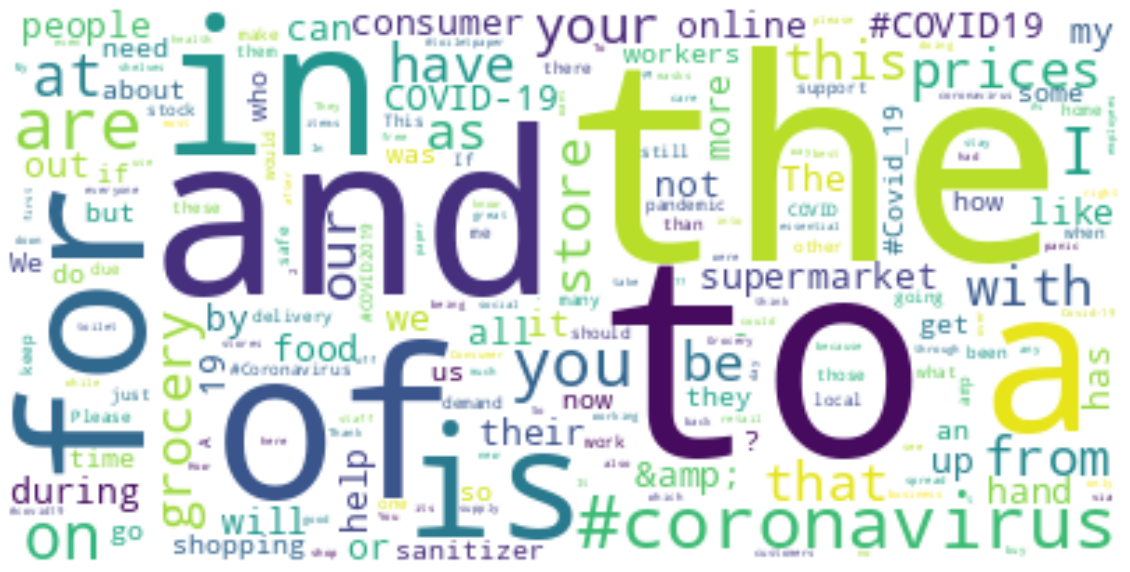

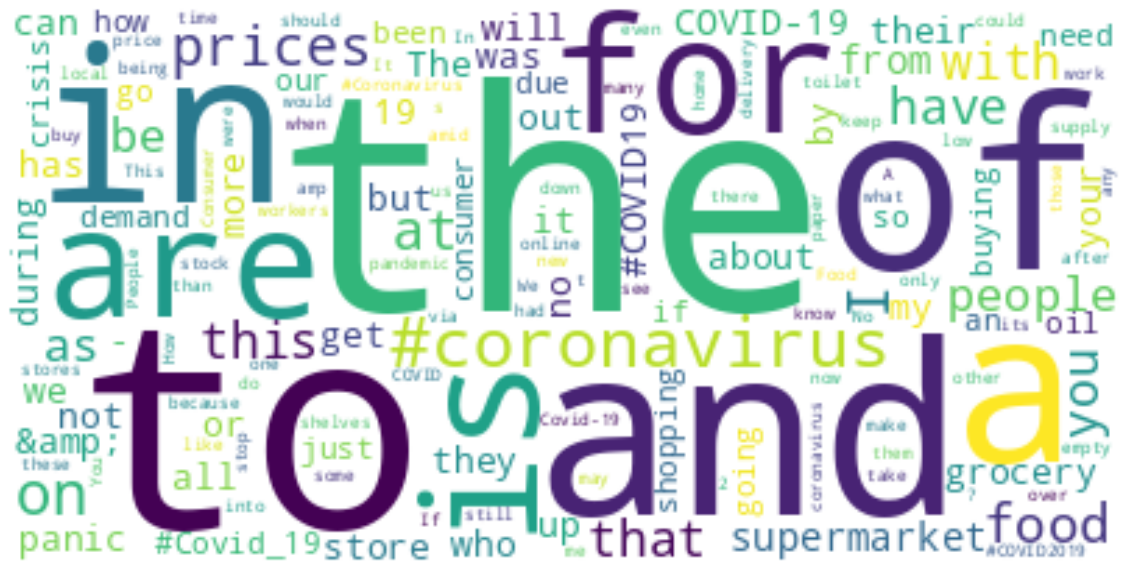

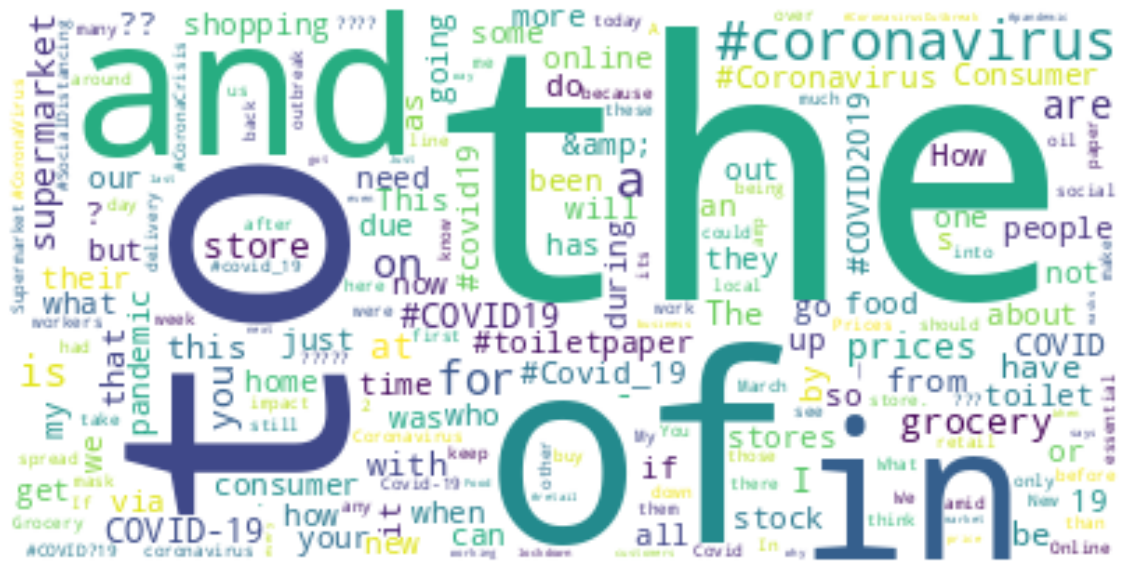

In [6]:
#generating into WordCloud
def drawWrdCld(df,path):
   wordcloud = WordCloud(background_color='white')
   wordcloud.generate_from_frequencies(frequencies=df)
   plt.figure(figsize = (20,15))
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.savefig(path)
   plt.show()
drawWrdCld(mainCountRawUni[0],'plots/partA_positive_wrdCloud.png')
drawWrdCld(mainCountRawUni[1],'plots/partA_negative_wrdCloud.png')
drawWrdCld(mainCountRawUni[2],'plots/partA_neutral_wrdCloud.png')

# Part B

In [13]:
#validation set accuracy by randomly guessing
matches = 0
predsRandom = [icMap[i] for i in np.random.randint(0,3,len(testSourceRaw))]
for i,j in zip(testSourceRaw["Sentiment"],predsRandom):
    if i == j :
        matches+=1
valAccRandom = matches/len(testSourceRaw)
print(f'Validation accuracy by randomly predicting : {matches/len(testSourceRaw)}')

#validation accuracy by predicting each example positive
matches = 0
predsPositive = ['Positive']*len(testSourceRaw)
for i in testSourceRaw["Sentiment"]:
    if i == "Positive" :
        matches+=1
valAccPos = matches/len(testSourceRaw)
print(f'Validation accuracy by predicting positive : {matches/len(testSourceRaw)}')

#improvements
print(f'Naive Bayes outperforms :\n1) Randome Baseline by {valAccNB - valAccRandom}\n1) Randome Baseline by {valAccNB - valAccPos}\nIn terms of accuracy over validation dataset')

Validation accuracy by randomly predicting : 0.34072274521712725
Validation accuracy by predicting positive : 0.4385059216519891
Naive Bayes outperforms :
1) Randome Baseline by 0.3273610689341026
1) Randome Baseline by 0.22957789249924077
In terms of accuracy over validation dataset


In [17]:
np.exp(cProbs[0])

0.4384556473974704

# Part C - Confusion Matrix

In [10]:
cm = confusion_matrix(list(testSourceRaw['Sentiment']),modelValPreds)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'],dtype=np.int32)
print("The confusion matrix for the given task : ")
print(cm_df)


The confusion matrix for the given task : 
          Negative  Neutral  Positive
Negative       905       55       272
Neutral        172      174       271
Positive       246       77      1121


In [11]:
modelTrainPreds = [predict(j,[(1,mainCountRawUni,denomUni)],cProbs,icMap)[0] for j in trainSourceRaw['CoronaTweet']]
cm = confusion_matrix(list(trainSourceRaw['Sentiment']),modelTrainPreds)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'],dtype=np.int32)
print("The confusion matrix over train for the given task : ")
print(cm_df)

The confusion matrix over train for the given task : 
          Negative  Neutral  Positive
Negative     12917      171      1078
Neutral       1364     3574      2158
Positive       714      177     15711


In [14]:
cm = confusion_matrix(list(testSourceRaw['Sentiment']),predsRandom)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'],dtype=np.int32)
print("The confusion matrix for random prediction : ")
print(cm_df)

The confusion matrix for random prediction : 
          Negative  Neutral  Positive
Negative       438      402       392
Neutral        207      205       205
Positive       496      469       479


In [16]:
predsRandomTrain = [icMap[i] for i in np.random.randint(0,3,len(trainSourceRaw))]
cm = confusion_matrix(list(trainSourceRaw['Sentiment']),predsRandomTrain)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'],dtype=np.int32)
print("The confusion matrix for random prediction : ")
print(cm_df)

The confusion matrix for random prediction : 
          Negative  Neutral  Positive
Negative      4746     4648      4772
Neutral       2407     2353      2336
Positive      5550     5502      5550


In [38]:
(cm_df.iloc[0]/sum(cm_df.iloc[0]))

Negative    0.339286
Neutral     0.340097
Positive    0.320617
Name: Negative, dtype: float64

In [24]:
cm = confusion_matrix(list(testSourceRaw['Sentiment']),predsPositive)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'],dtype=np.int32)
print("The confusion matrix for positive prediction : ")
print(cm_df)

The confusion matrix for positive prediction : 
          Negative  Neutral  Positive
Negative         0        0      1232
Neutral          0        0       617
Positive         0        0      1444


In [18]:
predsPositiveTrain = ["Positive"]*len(testSourceRaw)
cm = confusion_matrix(list(testSourceRaw['Sentiment']),predsPositiveTrain)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'],dtype=np.int32)
print("The confusion matrix for positive prediction : ")
print(cm_df)

The confusion matrix for positive prediction : 
          Negative  Neutral  Positive
Negative         0        0      1232
Neutral          0        0       617
Positive         0        0      1444


# Part-D : Stemming

In [140]:
class wordEdit :

    def __init__(self,stmLem = 1):
        if stmLem == 0:
            self.editor = None
        elif stmLem == 1 :
            self.editor = PorterStemmer()
        else :
            self.editor = WordNetLemmatizer()
        self.stmLem = stmLem

    def __call__(self, s : str):
        if self.stmLem == 0:
            return s
        elif self.stmLem == 1:
            return self.editor.stem(s)
        else:
            return self.editor.lemmatize(s)

def processInput(inText : str, wrdEdit : wordEdit,stopwords, keePuncs = 0):
    if keePuncs == 0:
        stemmed = [wrdEdit(i) for i in nltk.tokenize.word_tokenize(re.sub('[{}]'.format(string.punctuation), ' ', inText.lower()))]
    else :
        stemmed = [wrdEdit(i) for i in nltk.tokenize.word_tokenize(inText.lower())]
    rmStop = [i for i in stemmed if i not in stopwords]
    return ' '.join(rmStop)

def preProcessData(df, stmLem = 0, keePuncs = 0):
    # stmLem = 1 for stemming
    # stmLem = 2 for lemmatization
    # stmLem = 0 for none ,i.e, only stopword removal

    dfDict = {'Sentiment':[],'CoronaTweet':[]}
    for i in range(len(df['CoronaTweet'])):
        dfDict['Sentiment'].append(df['Sentiment'][i])
        dfDict['CoronaTweet'].append(processInput(df['CoronaTweet'][i],wordEdit(stmLem),set(nltk.corpus.stopwords.words('english')), keePuncs))
    return dfDict

In [142]:
#Stemming
trainSourceStem = pd.DataFrame(preProcessData(pd.read_csv('data/Corona_train.csv'),1,1))
testSourceStem = pd.DataFrame(preProcessData(pd.read_csv("data/Corona_validation.csv"),1,1))
mainCountStemUni, denomStemUni = getCounts(trainSourceStem,cMap)

matches = 0
for i,j in zip(trainSourceStem["Sentiment"],trainSourceStem["CoronaTweet"]):
    if i == predict(j,[(1,mainCountStemUni,denomStemUni)],cProbs,icMap)[0] :
        matches+=1
trainAccNB = matches/len(trainSourceStem)
print(f'Accuracy over training data : {matches/len(trainSourceStem)}')

matches = 0
modelValPreds = [predict(j,[(1,mainCountStemUni,denomStemUni)],cProbs,icMap)[0] for j in testSourceStem['CoronaTweet']]
for i,j in zip(testSourceStem["Sentiment"],modelValPreds):
    if i == j :
        matches+=1
valAccNB = matches/len(testSourceStem)
print(f'Accuracy over validation data : {matches/len(testSourceStem)}')


Accuracy over training data : 0.8153655186984999
Accuracy over validation data : 0.6923777710294564


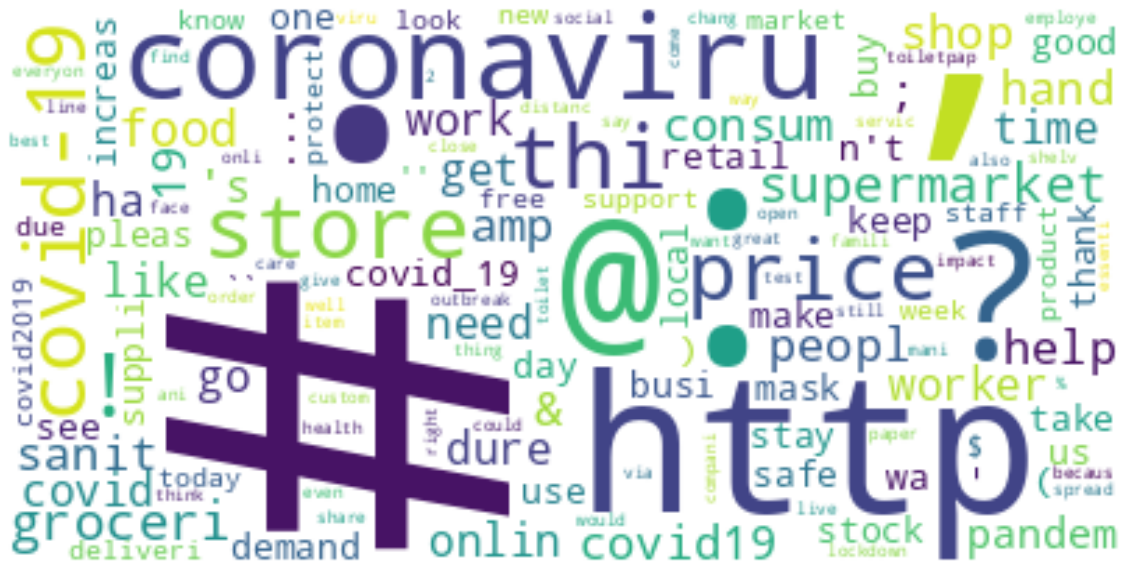

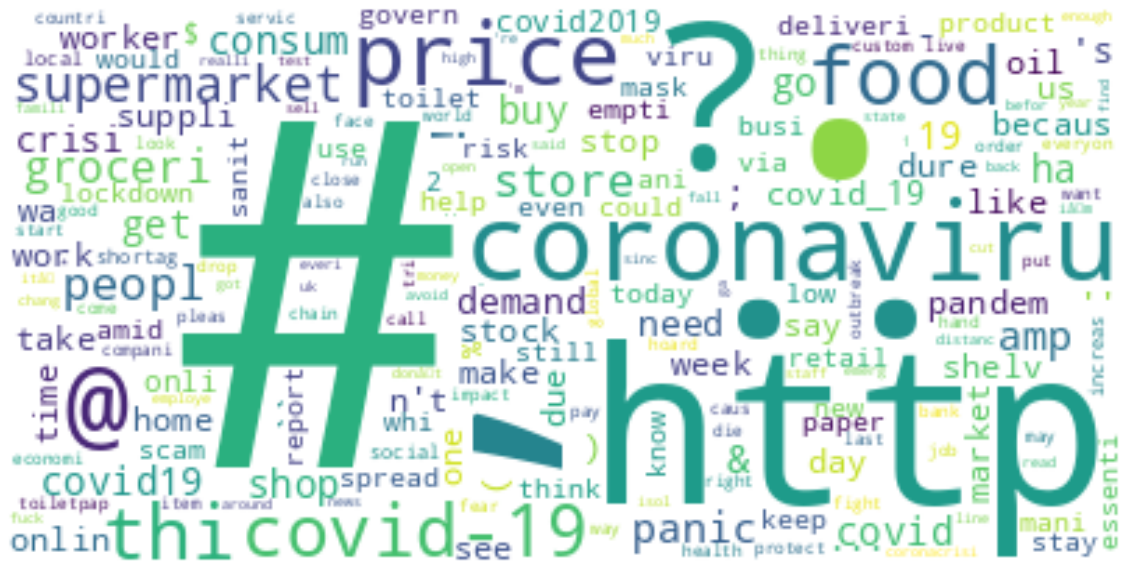

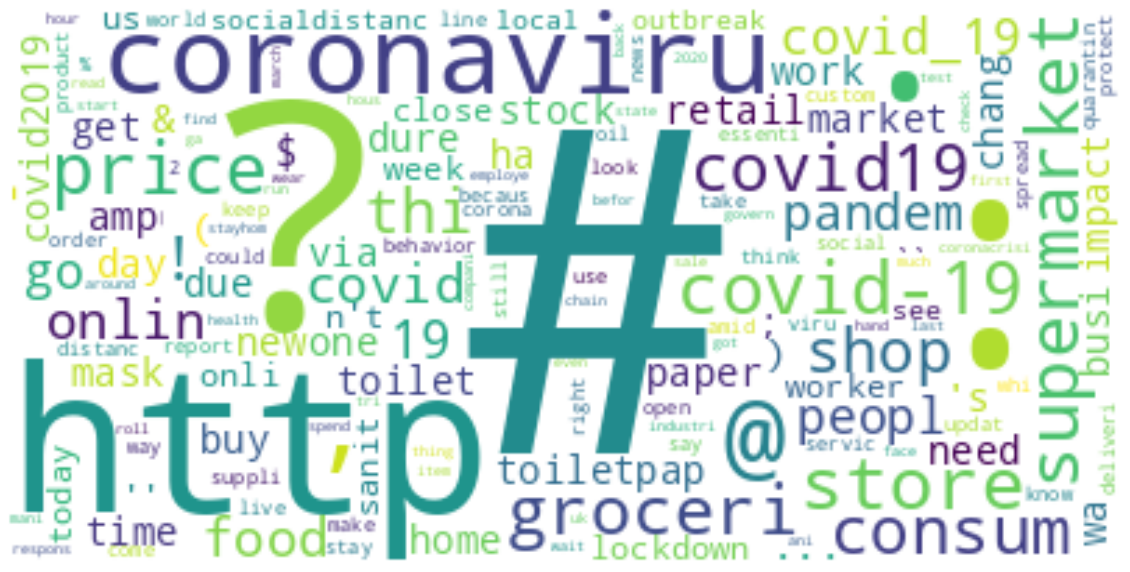

In [145]:
drawWrdCld(mainCountStemUni[0],'images/Q1/partD_positive_wrdCloudStem.png')
drawWrdCld(mainCountStemUni[1],'images/Q1/partD_negative_wrdCloudStem.png')
drawWrdCld(mainCountStemUni[2],'images/Q1/partD_neutral_wrdCloudStem.png')

In [143]:
#Lemmatizing
trainSourceLemm = pd.DataFrame(preProcessData(pd.read_csv('data/Corona_train.csv'),2,1))
testSourceLemm = pd.DataFrame(preProcessData(pd.read_csv("data/Corona_validation.csv"),2,1))
mainCountLemmUni, denomLemmUni = getCounts(trainSourceLemm,cMap)

matches = 0
for i,j in zip(trainSourceLemm["Sentiment"],trainSourceLemm["CoronaTweet"]):
    if i == predict(j,[(1,mainCountLemmUni,denomLemmUni)],cProbs,icMap)[0] :
        matches+=1
trainAccNB = matches/len(trainSourceLemm)
print(f'Accuracy over training data : {matches/len(trainSourceLemm)}')

matches = 0
modelValPredsLemm = [predict(j,[(1,mainCountLemmUni,denomLemmUni)],cProbs,icMap)[0] for j in testSourceLemm['CoronaTweet']]
for i,j in zip(testSourceLemm["Sentiment"],modelValPredsLemm):
    if i == j :
        matches+=1
valAccNB = matches/len(testSourceLemm)
print(f'Accuracy over validation data : {matches/len(testSourceLemm)}')

Accuracy over training data : 0.8290460595816607
Accuracy over validation data : 0.7023990282417248


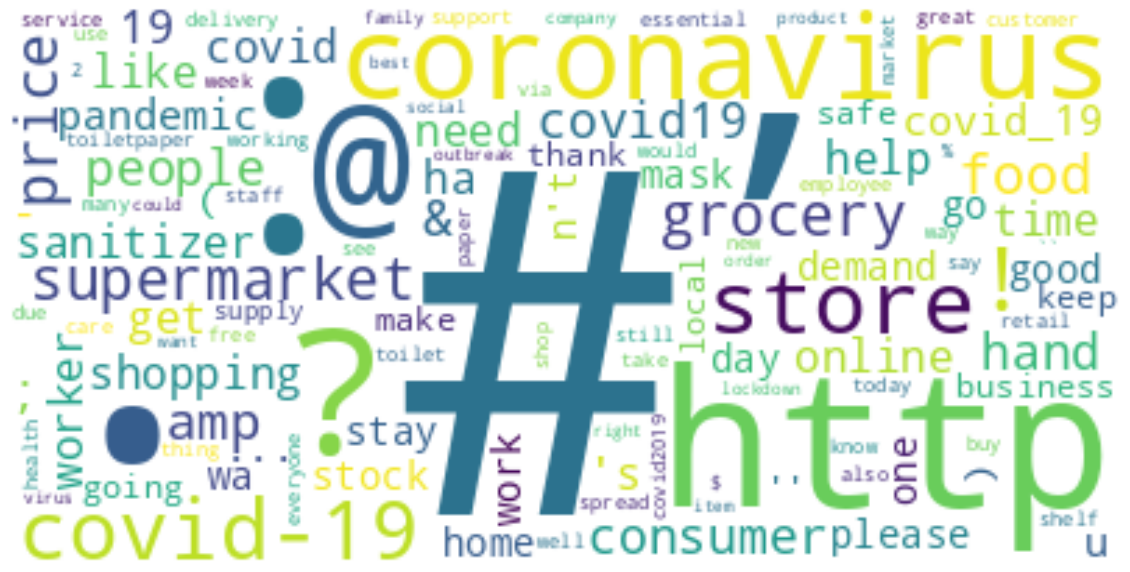

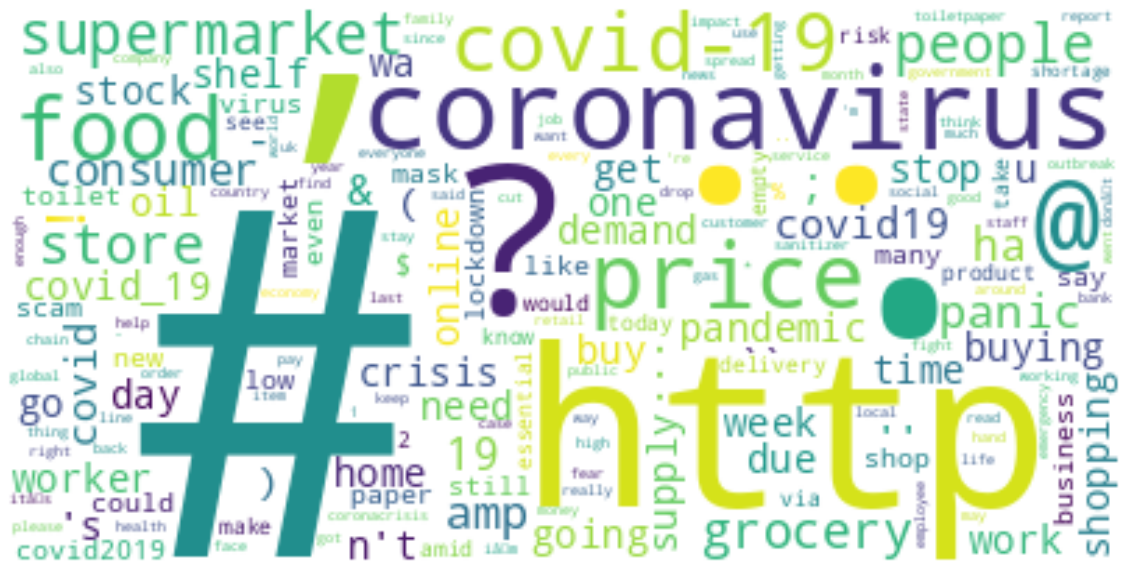

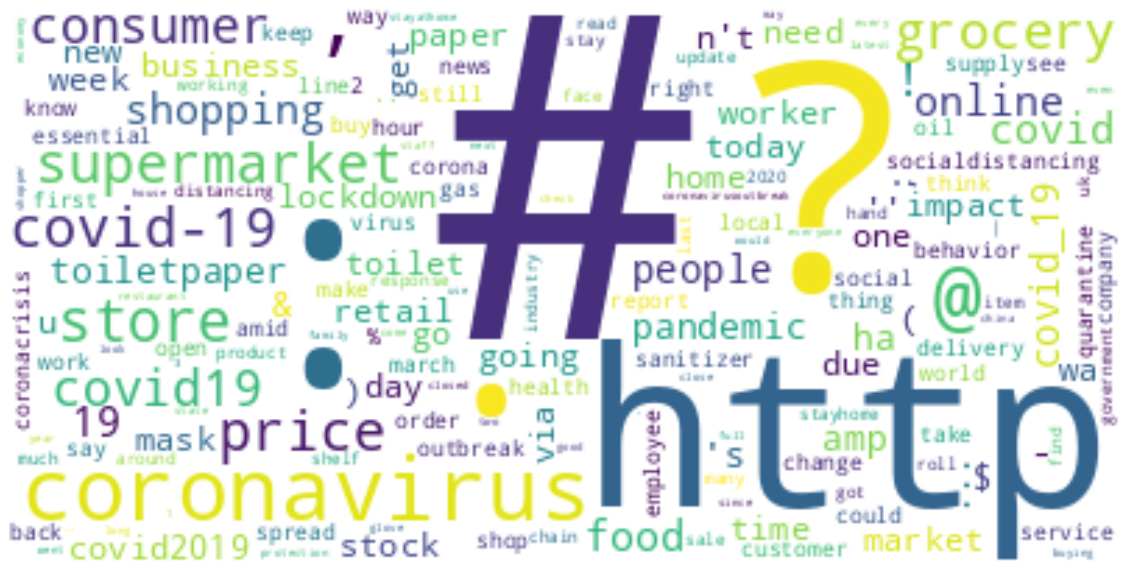

In [144]:
drawWrdCld(mainCountLemmUni[0],'images/Q1/partD_positive_wrdCloudLemm.png')
drawWrdCld(mainCountLemmUni[1],'images/Q1/partD_negative_wrdCloudLemm.png')
drawWrdCld(mainCountLemmUni[2],'images/Q1/partD_neutral_wrdCloudLemm.png')

In [168]:
#Nothing
trainSourceNoth = pd.DataFrame(preProcessData(pd.read_csv('data/Corona_train.csv'), 0))
testSourceNoth = pd.DataFrame(preProcessData(pd.read_csv("data/Corona_validation.csv"),0))
mainCountNothUni, denomNothUni = getCounts(trainSourceNoth,cMap)

matches = 0
for i,j in zip(trainSourceNoth["Sentiment"],trainSourceNoth["CoronaTweet"]):
    if i == predict(j,[(1,mainCountNothUni,denomNothUni)],cProbs,icMap)[0] :
        matches+=1
trainAccNB = matches/len(trainSourceNoth)
print(f'Accuracy over training data : {matches/len(trainSourceNoth)}')

matches = 0
modelValPredsNoth = [predict(j,[(1,mainCountNothUni,denomNothUni)],cProbs,icMap)[0] for j in testSourceNoth['CoronaTweet']]
for i,j in zip(testSourceNoth["Sentiment"],modelValPredsNoth):
    if i == j :
        matches+=1
valAccNB = matches/len(testSourceNoth)
print(f'Accuracy over validation data : {matches/len(testSourceNoth)}')

Accuracy over training data : 0.8399535178533699
Accuracy over validation data : 0.7109019131491041


# Part-E : Bi-grams and Feature Engineering

In [157]:
trainSourceStem = pd.DataFrame(preProcessData(pd.read_csv('data/Corona_train.csv'),1,1))
testSourceStem = pd.DataFrame(preProcessData(pd.read_csv("data/Corona_validation.csv"),1,1))

In [158]:
cProbs, cMap, icMap = getClassProbs(trainSourceStem["Sentiment"])
mainCountStemBi, denomStemBi = getCounts(trainSourceStem,cMap,n = 2)
bigramsStemPred = [(1,mainCountStemUni,denomStemUni),(2,mainCountStemBi,denomStemBi)]

In [156]:
matches = 0
trainPredStemBiGram = [predict(j,bigramsStemPred, cProbs, icMap)[0] for j in trainSourceStem["CoronaTweet"] ]
for i,j in zip(trainSourceStem["Sentiment"],trainPredStemBiGram):
    if i == j :
        matches+=1
trainAccNB = matches/len(trainSourceStem)
print(f'Accuracy over training data : {matches/len(trainSourceStem)}')

Accuracy over training data : 0.9490809211916332


In [159]:
matches = 0
testPredStemBiGram = [predict(j,bigramsStemPred, cProbs, icMap)[0] for j in testSourceStem["CoronaTweet"] ]
for i,j in zip(testSourceLemm["Sentiment"],testPredStemBiGram):
    if i == j :
        matches+=1
trainAccNB = matches/len(testSourceStem)
print(f'Accuracy over validation data : {matches/len(testSourceStem)}')

Accuracy over validation data : 0.682356513817188


In [160]:
mainCountStemTri, denomStemTri = getCounts(trainSourceStem,cMap,n = 3)
trigramsStemPred = [(1,mainCountStemUni,denomStemUni),(2,mainCountStemBi,denomStemBi),(3,mainCountStemTri,denomStemTri)]

In [162]:
matches = 0
trainPredStemTriGram = [predict(j,trigramsStemPred, cProbs, icMap)[0] for j in trainSourceStem["CoronaTweet"] ]
for i,j in zip(trainSourceStem["Sentiment"],trainPredStemTriGram):
    if i == j :
        matches+=1
trainAccNB = matches/len(trainSourceStem)
print(f'Accuracy over training data : {matches/len(trainSourceStem)}')

Accuracy over training data : 0.9861081766321572


In [161]:
matches = 0
testPredStemTriGram = [predict(j,trigramsStemPred, cProbs, icMap)[0] for j in testSourceStem["CoronaTweet"] ]
for i,j in zip(testSourceLemm["Sentiment"],testPredStemTriGram):
    if i == j :
        matches+=1
trainAccNB = matches/len(testSourceStem)
print(f'Accuracy over validation data : {matches/len(testSourceStem)}')

Accuracy over validation data : 0.6562405101730945


In [163]:
trainSourceStemPunc = pd.DataFrame(preProcessData(pd.read_csv('data/Corona_train.csv'),1))
testSourceStemPunc = pd.DataFrame(preProcessData(pd.read_csv("data/Corona_validation.csv"),1))

In [165]:
cProbs, cMap, icMap = getClassProbs(trainSourceStemPunc["Sentiment"])
mainCountStemBiPunc, denomStemBiPunc = getCounts(trainSourceStemPunc,cMap,n = 2)
mainCountStemUniPunc, denomStemUniPunc = getCounts(trainSourceStemPunc,cMap,n = 1)
bigramsStemPredPunc = [(1,mainCountStemUniPunc,denomStemUniPunc),(2,mainCountStemBiPunc,denomStemBiPunc)]

In [167]:
matches = 0
trainPredStemBiGramPunc = [predict(j,bigramsStemPredPunc, cProbs, icMap)[0] for j in trainSourceStemPunc["CoronaTweet"] ]
for i,j in zip(trainSourceStemPunc["Sentiment"],trainPredStemBiGramPunc):
    if i == j :
        matches+=1
trainAccNB = matches/len(trainSourceStemPunc)
print(f'Accuracy over training data : {matches/len(trainSourceStemPunc)}')

Accuracy over training data : 0.9644253116416649


In [166]:
matches = 0
testPredStemBiGramPunc = [predict(j,bigramsStemPred, cProbs, icMap)[0] for j in testSourceStemPunc["CoronaTweet"] ]
for i,j in zip(testSourceStemPunc["Sentiment"],testPredStemBiGramPunc):
    if i == j :
        matches+=1
trainAccNB = matches/len(testSourceStemPunc)
print(f'Accuracy over validation data : {matches/len(testSourceStemPunc)}')

Accuracy over validation data : 0.6966292134831461


# TF-IDF with Naive Bayes

Using tf-idf vectorizer library

In [217]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
trainX = trainSourceNoth['CoronaTweet']
trainY = trainSourceNoth['Sentiment']
testX = testSourceNoth['CoronaTweet']
testY = testSourceNoth['Sentiment']

In [227]:
tf_vectorizer = CountVectorizer() # or term frequency
trainXtf = tf_vectorizer.fit_transform(trainX)
testXtf = tf_vectorizer.transform(testX)
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(trainXtf, trainY)

MultinomialNB()

In [237]:
predY = naive_bayes_classifier.predict(testXtf)

In [238]:
predY

array(['Negative', 'Negative', 'Negative', ..., 'Neutral', 'Negative',
       'Negative'], dtype='<U8')

In [240]:
np.where((predY == np.array(testY)) == True)[0].shape[0]/predY.shape[0]

0.6963255390221682

# Part-F : Domain Adaptation

In [147]:
#merging two datasets
def domainMerge(source : pd.DataFrame, domain: pd.DataFrame):
    dfFinal = {"Sentiment" : [], "CoronaTweet" : []}
    for i,j in zip(source['Sentiment'], source['CoronaTweet']):
        dfFinal["Sentiment"].append(i)
        dfFinal["CoronaTweet"].append(j)

    for i,j in zip(domain['Sentiment'], domain['Tweet']):
        dfFinal["Sentiment"].append(i)
        dfFinal["CoronaTweet"].append(j)
    return pd.DataFrame(dfFinal)

In [148]:
domainVal = pd.read_csv('data/Domain_Adaptation/Twitter_validation.csv')
domainVal.rename(columns={'Tweet':'CoronaTweet'},inplace=True)
domainValidation = pd.DataFrame(preProcessData(domainVal,1,1))

In [151]:
def domainAdaptationAccuracies(n):

    domainAdaptation1 = pd.read_csv("data/Domain_Adaptation/Twitter_train_"+str(n)+".csv")
    trainDomain1Clean = pd.DataFrame(preProcessData(domainMerge(trainSourceStem,domainAdaptation1),1,1))
    cProbs, cMap, icMap = getClassProbs(trainDomain1Clean["Sentiment"])
    mainCountDomainUni10, denomDomainUni10 = getCounts(trainDomain1Clean,cMap,n = 1)
    matches = 0
    tot = 0
    trainPredCleanDomain1= [predict(j,[(1,mainCountDomainUni10,denomDomainUni10)],cProbs,icMap)[0] for j in trainDomain1Clean["CoronaTweet"] ]
    for i,j in zip(trainDomain1Clean["Sentiment"],trainPredCleanDomain1):
        tot+=1
        if i == j :
            matches+=1
    trainAccNB = matches/len(trainDomain1Clean)
    print(f'Accuracy over training data : {matches/len(trainDomain1Clean)}')

    matches = 0
    tot = 0
    testPredCleanBiGram = [predict(j,[(1,mainCountDomainUni10,denomDomainUni10)],cProbs,icMap)[0] for j in domainValidation["CoronaTweet"] ]
    for i,j in zip(domainValidation["Sentiment"],testPredCleanBiGram):
        tot+=1
        if i == j :
            matches+=1
    trainAccNB = matches/len(domainValidation)
    print(f'Accuracy over validation data : {matches/len(domainValidation)}')

In [152]:
domainAdaptationAccuracies(1)

Accuracy over training data : 0.8148050718156469
Accuracy over validation data : 0.46785950960901257


In [55]:
domainAdaptationAccuracies(2)

Accuracy over training data : 0.8340058694057226
Accuracy over validation data : 0.4546056991385023


In [56]:
domainAdaptationAccuracies(5)

Accuracy over training data : 0.8342570052312632
Accuracy over validation data : 0.464546056991385


In [57]:
domainAdaptationAccuracies(10)

Accuracy over training data : 0.8336297124275989
Accuracy over validation data : 0.476805831676607


In [58]:
domainAdaptationAccuracies(25)

Accuracy over training data : 0.8310184072667852
Accuracy over validation data : 0.47514910536779326


In [59]:
domainAdaptationAccuracies(50)

Accuracy over training data : 0.8264703288951591
Accuracy over validation data : 0.48641484426772696


In [60]:
domainAdaptationAccuracies(100)

Accuracy over training data : 0.8179101089588378
Accuracy over validation data : 0.4900596421471173


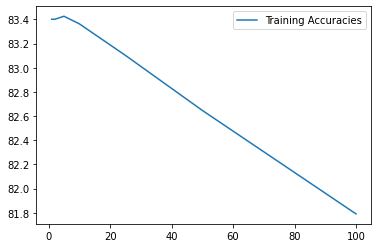

In [75]:
trainAcc = [83.40085231756721,83.40058694057226,83.42570052312632, 83.36297124275989, 83.10184072667852, 82.64703288951591, 81.79101089588378]
valiAcc = [45.46056991385023,46.4546056991385,47.6805831676607,47.514910536779326,48,641484426772696,49.00596421471173]
X = [1,2,5,10,25,50,100]
plt.plot(X,trainAcc,label = 'Training Accuracies')
#plt.plot(X,valiAcc,label = 'Validation Accuracies')
plt.legend()
plt.show()

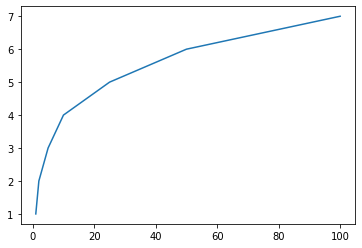

In [74]:
Y = [1,2,3,4,5,6,7]
plt.plot(X,Y)

In [84]:
def domainAdaptationAccuraciesTarget(n):

    domainAdaptation1 = pd.read_csv("data/Domain_Adaptation/Twitter_train_"+str(n)+".csv")
    domainAdaptation1 = domainAdaptation1.rename(columns={'Tweet':"CoronaTweet"})
    trainDomain1Clean = pd.DataFrame(preProcessData(domainAdaptation1,1))
    cProbs, cMap, icMap = getClassProbs(trainDomain1Clean["Sentiment"])
    mainCountDomainUni10, denomDomainUni10 = getCounts(trainDomain1Clean,cMap,n = 1)
    matches = 0
    tot = 0
    trainPredCleanDomain1= [predict(j,[(1,mainCountDomainUni10,denomDomainUni10)],cProbs,icMap)[0] for j in trainDomain1Clean["CoronaTweet"] ]
    for i,j in zip(trainDomain1Clean["Sentiment"],trainPredCleanDomain1):
        tot+=1
        if i == j :
            matches+=1
    trainAccNB = matches/len(trainDomain1Clean)
    print(f'Accuracy over training data : {matches/len(trainDomain1Clean)}')

    matches = 0
    tot = 0
    testPredCleanBiGram = [predict(j,[(1,mainCountDomainUni10,denomDomainUni10)],cProbs,icMap)[0] for j in domainValidation["CoronaTweet"] ]
    for i,j in zip(domainValidation["Sentiment"],testPredCleanBiGram):
        tot+=1
        if i == j :
            matches+=1
    trainAccNB = matches/len(domainValidation)
    print(f'Accuracy over validation data : {matches/len(domainValidation)}')

In [85]:
domainAdaptationAccuraciesTarget(1)

Accuracy over training data : 0.98
Accuracy over validation data : 0.3548707753479125


In [86]:
domainAdaptationAccuraciesTarget(2)

Accuracy over training data : 0.9733333333333334
Accuracy over validation data : 0.39595758780649437


In [91]:
domainAdaptationAccuraciesTarget(5)

Accuracy over training data : 0.964
Accuracy over validation data : 0.4430086149768058


In [92]:
domainAdaptationAccuraciesTarget(10)

Accuracy over training data : 0.9486666666666667
Accuracy over validation data : 0.4860834990059642


In [93]:
domainAdaptationAccuraciesTarget(25)

Accuracy over training data : 0.9157333333333333
Accuracy over validation data : 0.48906560636182905


In [94]:
domainAdaptationAccuraciesTarget(50)

Accuracy over training data : 0.8862666666666666
Accuracy over validation data : 0.5155732273028496


In [95]:
domainAdaptationAccuraciesTarget(100)

Accuracy over training data : 0.8666666666666667
Accuracy over validation data : 0.5603048376408217


In [5]:
valiAccS = [45.46056991385023,45.46056991385023,46.4546056991385,47.6805831676607,47.514910536779326,48.641484426772696,49.00596421471173]
valiAccNS = [35.48707753479125,39.595758780649437,44.30086149768058,48.60834990059642,48.906560636182905,51.55732273028496,56.03048376408217]
X = [1,2,5,10,25,50,100]

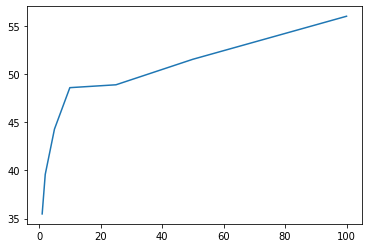

In [7]:
import matplotlib.pyplot as plt
plt.plot(X,valiAccNS)
plt.savefig('plots/temp.png')

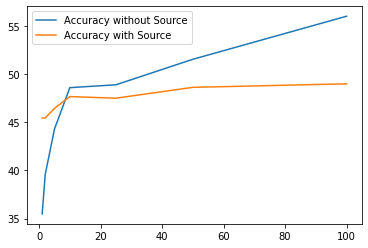

In [115]:
plt.plot(X,valiAccNS, label = 'Accuracy without Source')
plt.plot(X,valiAccS, label = 'Accuracy with Source')
plt.legend()
plt.savefig('partFaccuracies.png')
plt.show()

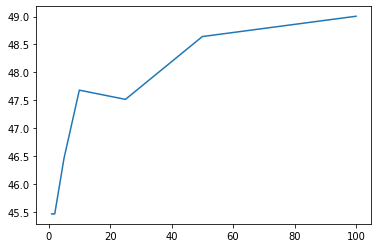

In [3]:
import pandas as pd
df = pd.read_csv('../../data/Corona_train.csv')

In [4]:
df

ID Sentiment                                        CoronaTweet
0      22979  Positive  I see all kinds of academics already whipping ...
1       9880  Negative  @HenrySmithUK can you raise with Boris please ...
2      35761  Negative  It s a confusing odd time for the shopping pub...
3      37968  Positive  Blog Summary: The Impact of COVID-19 on the Ca...
4      19709   Neutral  ??????? ??????? ???\r\r\nWaiting in a long Que...
...      ...       ...                                                ...
37859  20253   Neutral  DOUBLE TAP ??IF YOU REMEMBER BEING EMPLOYED?\r...
37860  38926  Positive  Struggling to understand why supermarkets or f...
37861  35889  Positive  For anyone interested in the checklist on cons...
37862  40641  Positive  Do you agree with the hypothesis that Indian s...
37863  26063   Neutral  In Richmond, local boutiques and thrift stores...

[37864 rows x 3 columns]

with open()

df